# Ads Analysis

This Ads analysis used the data from the book **A collection of data science take-home challenge** and the analytics follows [Ads Analysis - Solution](https://productds.com/wp-content/uploads/ad_analysis.html).

## Challenge Description

Company XYZ is a food delivery company. Like pretty much any other site, in order to get customers, they have been relying significantly on online ads, such as those you see on Google or Facebook.

At the moment, they are running 40 different ad campaigns and want you to help them understand their performance.
Specifically, you are asked to:
* If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.
* For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).
* Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

data = pd.read_csv("ad_table.csv")
data.shape

(2115, 7)

In [2]:
data['date'] = pd.to_datetime(data['date'])

In [21]:
data.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [9]:
len(set(data['ad']))

40

## Data

* date : all data are aggregated by date
* shown : the number of ads shown on a given day all over the web. Impressions are free. That is, companies pay only if a user clicks on the ad, not to show it
* clicked : the number of clicks on the ads. This is what companies pay for. By clicking on the ad, the user is brought to the site
* converted : the number of conversions on the site coming from ads. To be counted, a conversion has to happen on the same day as the ad click.
* avg_cost_per_click : on an average, how much it cost each of those clicks total_revenue : how much revenue came from the conversions
* ad : we have several different ad groups. This shows which ad group we are considering

In [11]:
print(data.drop(["date", "ad"], axis=1).describe())

               shown       clicked    converted  avg_cost_per_click  \
count    2111.000000   2111.000000  2111.000000         2111.000000   
mean    68323.650876   3059.480815   126.611559            1.374514   
std     48918.526354   3786.298845   233.609539            0.754567   
min         0.000000      0.000000     0.000000            0.000000   
25%     28030.500000    744.000000    18.000000            0.760000   
50%     54029.000000   1392.000000    41.000000            1.400000   
75%     97421.000000   3376.500000   103.000000            1.920000   
max    192507.000000  20848.000000  1578.000000            4.190000   

       total_revenue  
count    2111.000000  
mean     1970.395812  
std      3944.743726  
min         0.000000  
25%       236.665000  
50%       554.510000  
75%      1612.570000  
max     39623.710000  


### Remove negative revenue

In [3]:
#Remove those
data = data.query('total_revenue >= 0')

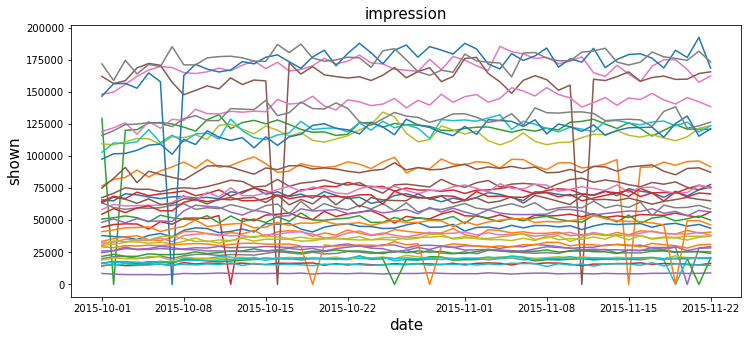

In [26]:
plt.figure(figsize=(12, 5))
for group in set(data['ad']):
    subdf = data[data.ad == group]
    plt.plot(subdf["date"], subdf["shown"])
plt.title("impression", fontsize=15)
plt.xlabel("date", fontsize=15)
plt.ylabel("shown", fontsize=15)
plt.show()

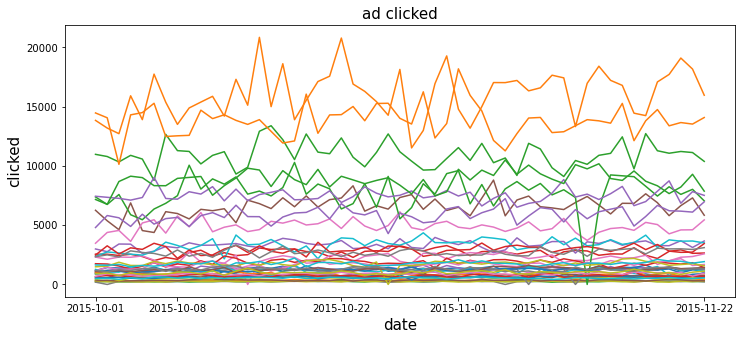

In [4]:
data = data.query('shown > 0')

plt.figure(figsize=(12, 5))
for group in set(data['ad']):
    subdf = data[data.ad == group]
    plt.plot(subdf["date"], subdf["clicked"])
plt.title("ad clicked", fontsize=15)
plt.xlabel("date", fontsize=15)
plt.ylabel("clicked", fontsize=15)
plt.show()

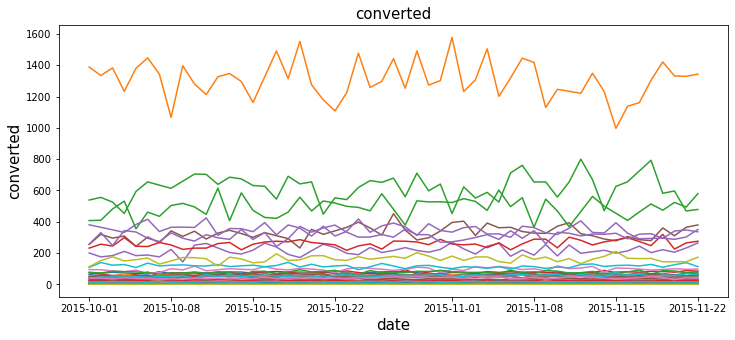

In [5]:
data = data.query('clicked > 0')

plt.figure(figsize=(12, 5))
for group in set(data['ad']):
    subdf = data[data.ad == group]
    plt.plot(subdf["date"], subdf["converted"])
plt.title("converted", fontsize=15)
plt.xlabel("date", fontsize=15)
plt.ylabel("converted", fontsize=15)
plt.show()

### Q: If you had to identify the 5 best ad groups, which ones would be? Which metric did you choose to identify the best ones? Why? Explain the pros of your metric as well as the possible cons. From a business perspective, choosing that metric implies that you are focusing on what?

There are obviously tons of ad related metric. And they are all plausible and useful in different situations, depending on the main business focus of a given company. A few examples are:

**Click-through-rate (CTR)**, # of clicks/ # of impressions, i.e. of all people seeing the ad, how many click on it?
* Pros: as discussed extensively in this course case studies, it is great to identify demand from users. Also, since it only takes into account what the user does after seeing the ad, it can be easily estimated and allows to test and improve ad characteristics to maximize the number of users coming to the site

* Cons: It has no information about what the user does once they come to the site and costs. A very high CTR is not that useful is no one of those users convert. It can also easily be tricked via click-bait ads.
This metric is purely growth-based when the goal is to bring users to the site

**Conversion rate (CR)**, # of conversions/ # of impressions, i.e. of all people seeing the ad, how many people end up becoming customers?
* Pros: Fixes most of CTR issues. After all, the goal of an ad is to get customers, and this is what this metric represents.

* Cons: It has no information about costs. Also, conversion on the site highly depends on the product. An ad could be great in capturing demand, but if the product is bad, no one converts. Finally, how to link conversion to an ad click is pretty messy, conversion might happen after a long time, might happen after multiple visits through different channels, etc.
This metric combines both growth and product.

**Profits**, revenue from conversions minus ad costs
* Pros: Very concrete and business driven. Am I making money via ads?
* Cons: Same as CR, hard to define revenue from an ad, not only there are the issues described above, but here you would need to predict user lifetime value to see if an ad is profitable. Also, it only considers users after they click on the ad. It has no information about the top of the funnel, i.e. how many users see the ad and choose to not click.

This metric focuses on the business/product side, but it is hardly useful from a growth standpoint. It is typically used by very large companies whose main goal it being profitable.

For this exercise, let’s look into profits and CTR. We will pick the top 5 ads based on CTR as long as profits are above a certain threshold.

In [46]:
#Let's get CTR and profits per ad group on an avg
data_rank = data.groupby('ad').apply(
             lambda x: pd.Series({
                       'CTR': (x['clicked']/x['shown']).mean(),
                       'conversion_rate': (x['converted']/x['shown']).mean(),
                       'profits': (x['total_revenue']-x['clicked']*x['avg_cost_per_click']).mean(),
                       'impression': x['shown'].mean()
  })
).reset_index()

#check minimum ad count just to make sure we have enough data for all groups. Looks like we are fine
print(data_rank['impression'].min())


8461.096153846154


In [43]:
data_rank.head()

,ad,CTR,conversion_rate,profits,impression
0,ad_group_1,0.039003,0.000680,-1901.937547,69345.566038
1,ad_group_10,0.014175,0.000166,-1650.159615,117701.365385
2,ad_group_11,0.063575,0.003078,-1346.640408,19448.979592
3,ad_group_12,0.061022,0.005578,-1194.148431,29145.549020
4,ad_group_13,0.085635,0.008103,-3573.196275,161519.176471


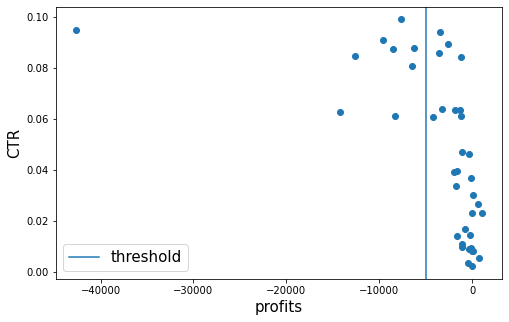

In [36]:
plt.figure(figsize=(8, 5))
plt.scatter(data_rank['profits'], data_rank['CTR'])
plt.axvline(x=-5000, label='threshold')
plt.xlabel('profits', fontsize=15)
plt.ylabel('CTR', fontsize=15)
plt.legend(fontsize=15)
plt.show()

Based on the plot, the author (from [Ads Analysis - Solution](https://productds.com/wp-content/uploads/ad_analysis.html)) defined as threshold for profitability -5K (indciated by the vertical line). We will remove all ads below that, and then find the ads with the **highest CTR** among the remaining ones. **Note that here we are considering short term revenue from the ad, and we are expecting that number to be negative. An ad should be positive when taking into account a user life time value (as usual, lifetime -> 1 yr)**.

The Top 5 campaigns (highest CTR) are

In [37]:
print(data_rank.query('profits > -5000').sort_values('CTR', ascending=False).head(5))

             ad       CTR      profits          count
10  ad_group_19  0.094188 -3460.419038   19506.884615
20  ad_group_28  0.089191 -2644.280943   19886.339623
4   ad_group_13  0.085635 -3573.196275  161519.176471
27  ad_group_34  0.084257 -1189.270000   35371.622642
35   ad_group_5  0.063862 -3233.796538   52406.461538


The Top 5 campaigns (if defined by highest conversion rate) are

In [41]:
print(data_rank.query('profits > -5000').sort_values('conversion_rate', ascending=False).head(5))

             ad       CTR  conversion_rate      profits          count
4   ad_group_13  0.085635         0.008103 -3573.196275  161519.176471
27  ad_group_34  0.084257         0.007363 -1189.270000   35371.622642
3   ad_group_12  0.061022         0.005578 -1194.148431   29145.549020
35   ad_group_5  0.063862         0.004114 -3233.796538   52406.461538
2   ad_group_11  0.063575         0.003078 -1346.640408   19448.979592


### Q: For each group, predict how many ads will be shown on Dec, 15

The most common ways to do this are either using gam or using some time series package. In this case, we will do via the time series package prophet.

In [6]:
data_ts = data.groupby(['ad', 'date']).apply(
             lambda x: pd.Series({'impression': x['shown'].mean()})).reset_index()

In [7]:
data_ts.head()

,ad,date,impression
0,ad_group_1,2015-10-01,65877.0
1,ad_group_1,2015-10-02,65100.0
2,ad_group_1,2015-10-03,70658.0
3,ad_group_1,2015-10-04,69809.0
4,ad_group_1,2015-10-05,68186.0


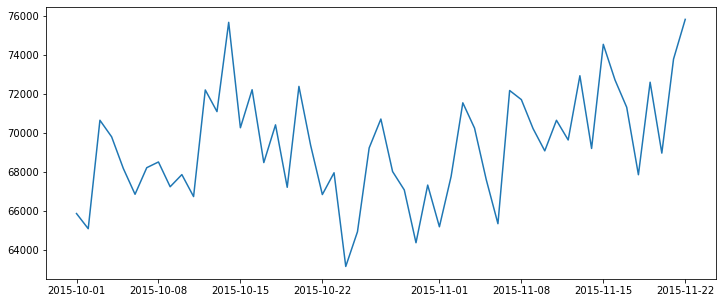

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(data_ts[data_ts.ad == 'ad_group_1']["date"], data_ts[data_ts.ad == 'ad_group_1']["impression"])
plt.show()

In [9]:
import fbprophet

Importing plotly failed. Interactive plots will not work.


In [12]:
data_ad1 = data_ts[data_ts.ad == 'ad_group_1']

data_ad1['ds'] = data_ad1['date']
data_ad1.rename({'impression': 'y'}, axis=1, inplace=True)
data_ad1.set_index('date', inplace=True)

#build the model
ts = fbprophet.Prophet()
ts.fit(data_ad1)

<ipython-input-12-f8a2699757cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ad1['ds'] = data_ad1['date']
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


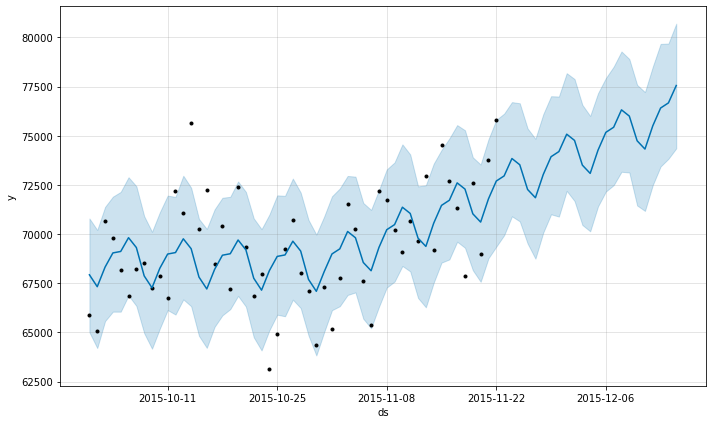

In [14]:
days_predictions = (pd.to_datetime("2015-12-15")-data_ad1['ds'].max()).days
future_data = ts.make_future_dataframe(periods = days_predictions)
predictions = ts.predict(future_data)
  
#let's plot them
ts.plot(predictions)
plt.show()

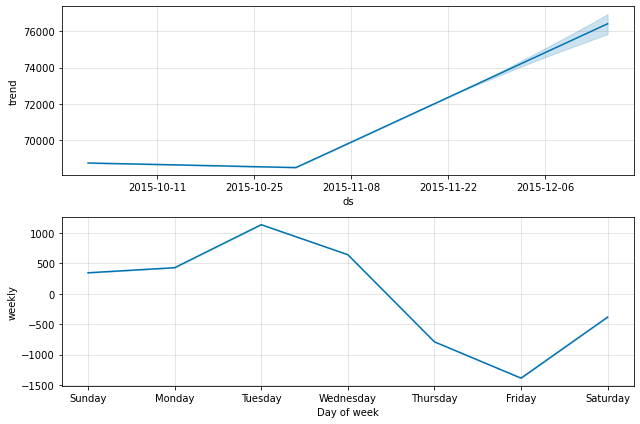

In [15]:
ts.plot_components(predictions)
plt.show()

We can see that there is some (very very small) weekly variation. Most importantly, the time series overall is pretty flat in October and starts going up in Nov. Predictions for Dec 15 tend to be up given that the model assumes the time series keeps following its most recent trend. Obviously, this would be much more useful with yearly data, so we would be able to capture yearly seasonality.

Let’s now do it for each ad groups and get the predictions:

In [18]:
predictions_all_groups = pd.DataFrame({'ad_group':data['ad'].unique(),
                                           'date': pd.to_datetime("2015-12-15")})
prediction_dec_15 = []                                           
   
#We will do it via a for loop through all the ad groups
for level in predictions_all_groups.ad_group:
    
    #subset data, only keep one ad group per iteration and columns needed
    tmp = data.loc[data['ad']==level][["date", "shown"]]

    #change column names and index
    tmp['ds'] = tmp['date']
    tmp.rename({'shown': 'y'}, axis=1, inplace=True)
    tmp.set_index('date', inplace=True)
     
    #build the model
    ts_tmp = fbprophet.Prophet()
    ts_tmp.fit(tmp)
     
    #make predictions until Dec 15. This is the number of days for which we need a prediction to get to Dec 15
    days_predictions_tmp = (pd.to_datetime("2015-12-15")-tmp['ds'].max()).days
    future_data_tmp = ts_tmp.make_future_dataframe(periods = days_predictions_tmp)
    predictions_tmp = ts_tmp.predict(future_data_tmp)
     
    #store results for the last day, i.e. Dec 15 prediction
    prediction_dec_15.append(round(predictions_tmp['yhat'].iat[-1]))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [19]:
predictions_all_groups['predictions'] = prediction_dec_15
print(predictions_all_groups)

       ad_group       date  predictions
0    ad_group_1 2015-12-15        77558
1    ad_group_2 2015-12-15        50305
2    ad_group_3 2015-12-15       152888
3    ad_group_4 2015-12-15        94679
4    ad_group_5 2015-12-15        54750
5    ad_group_6 2015-12-15        40587
6    ad_group_7 2015-12-15        56988
7    ad_group_8 2015-12-15        47171
8    ad_group_9 2015-12-15       124642
9   ad_group_10 2015-12-15       127043
10  ad_group_11 2015-12-15        19964
11  ad_group_12 2015-12-15        28000
12  ad_group_13 2015-12-15       162073
13  ad_group_14 2015-12-15         8715
14  ad_group_15 2015-12-15        15773
15  ad_group_16 2015-12-15        30494
16  ad_group_17 2015-12-15       134101
17  ad_group_18 2015-12-15        89749
18  ad_group_19 2015-12-15        19889
19  ad_group_20 2015-12-15       120417
20  ad_group_21 2015-12-15        28320
21  ad_group_22 2015-12-15        26866
22  ad_group_23 2015-12-15        48616
23  ad_group_24 2015-12-15        37394


### Q: Cluster ads into 3 groups: the ones whose `avg_cost_per_click` is going up, flat and going down

The best way to answer this is to build a linear regression for each ad group. `Cost_per_click` will be the y value and the x axis is days as a number (1,2,3,etc). We will then check the coefficient of the regression:

Positive and significant coefficient -> going up
Negative and significant coefficient -> going down
Non-significant coefficient -> flat


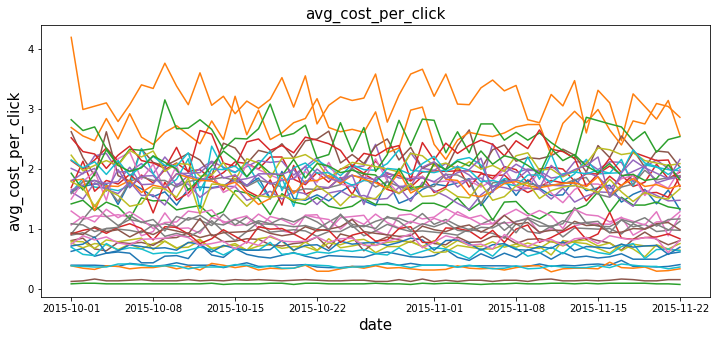

In [20]:
plt.figure(figsize=(12, 5))
for group in set(data['ad']):
    subdf = data[data.ad == group]
    plt.plot(subdf["date"], subdf["avg_cost_per_click"])
plt.title("avg_cost_per_click", fontsize=15)
plt.xlabel("date", fontsize=15)
plt.ylabel("avg_cost_per_click", fontsize=15)
plt.show()

In [22]:
import statsmodels.api as sm

coefficient = []
p_value = []

#for loop over all ad groups
for level in data['ad'].unique():
    
    data_reg = data.loc[data['ad']==level][["date", "avg_cost_per_click"]]
    data_reg['date'] = (data_reg['date'] - data_reg['date'].min()).dt.days
  
    data_reg['intercept'] = 1 ## why 1??
  
    lr = sm.OLS(data_reg['avg_cost_per_click'], data_reg.drop('avg_cost_per_click', axis=1)).fit()
    
    coefficient.append(lr.params[0])
    p_value.append(lr.pvalues[0])


#put all together in a datframe
lr_output = pd.DataFrame({'ad_group': data['ad'].unique(), 'coefficients': coefficient, 'p_value': p_value})

#classify based on the rule described above. we use Bonferroni rule for significance
lr_output['cluster'] = np.where(lr_output['p_value']>0.05/40, 'flat',
                       np.where(lr_output['coefficients']<0, 'going_down', 'going_up'))


In [23]:
lr_output.head(len(lr_output))

,ad_group,coefficients,p_value,cluster
0,ad_group_1,0.000926,0.145429,flat
1,ad_group_2,-0.000006,0.991095,flat
2,ad_group_3,0.002445,0.255564,flat
3,ad_group_4,-0.000577,0.804445,flat
4,ad_group_5,-0.001018,0.440261,flat
5,ad_group_6,-0.001734,0.077129,flat
6,ad_group_7,-0.002569,0.120068,flat
7,ad_group_8,-0.002689,0.026231,flat
8,ad_group_9,0.000044,0.434626,flat
9,ad_group_10,-0.000161,0.861238,flat


In [24]:
print(lr_output['cluster'].value_counts())

flat    40
Name: cluster, dtype: int64


Looks like everything is **flat**. W/o using the **Bonferroni correction** (i.e. had we chosen a less aggressive p-value threshold), we would have likely found some significant ads.

Also, via a linear regression, we are looking at the overall trend. That is, old data points weigh just as much as the most recent ones. Had we focused only on the most recent data, we obviously might have found different results.